In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import artm

batch_vectorizer = artm.BatchVectorizer(data_path='datasets/mmro_order', data_format='batches')

background_topics = []
domain_topics = []
all_topics = []

for i in range(0, 52):
    if i < 50:
        topic_name = str(i)
        domain_topics.append(topic_name)
    else:
        topic_name = "b" + str(i)
        background_topics.append(topic_name)
    all_topics.append(topic_name)
        
def prepare(model):
    model.load_dictionary(dictionary_name='dictionary', dictionary_path='datasets/mmro_order/dictionary')
    model.initialize(dictionary_name='dictionary')
    # will this cooc dictionaries match?
    model.load_dictionary(dictionary_name='pPMI_w100', dictionary_path='datasets/mmro/pPMI_w100_dictionary')
    model.load_dictionary(dictionary_name='pPMI_doc', dictionary_path='datasets/mmro/pPMI_doc_dictionary')
 
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                      use_unigram_document_model=False, # где-то сохраняется, сколько раз pwd = 0?
                                      dictionary_name='dictionary'))

    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', 
                                           topic_names = domain_topics))

    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', 
                                            topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop10_pPMI_w100', 
                                         num_tokens=10, 
                                         dictionary_name = 'pPMI_w100',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop100_pPMI_w100', 
                                         num_tokens=100, 
                                         dictionary_name = 'pPMI_w100',
                                         topic_names = domain_topics))
    
    model.scores.add(artm.TopTokensScore(name='DomainTop10_pPMI_doc', 
                                         num_tokens=10, 
                                         dictionary_name = 'pPMI_doc',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop100_pPMI_doc', 
                                         num_tokens=100, 
                                         dictionary_name = 'pPMI_doc',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='BackgroundTopTokensScore', 
                                         num_tokens=10, 
                                         topic_names = background_topics))

    model.scores.add(artm.TopicKernelScore(name='DomainTopicKernel_pPMI_w100', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'pPMI_w100',
                                           topic_names = domain_topics))
    
    model.scores.add(artm.TopicKernelScore(name='DomainTopicKernel_pPMI_doc', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'pPMI_doc',
                                           topic_names = domain_topics))

    model.scores.add(artm.TopicKernelScore(name='BackgroundTopicKernelScore', 
                                           probability_mass_threshold=0.25, 
                                           topic_names = background_topics))
    
    model.scores.add(artm.TopicMassPhiScore(name='BackgroundMassScore',  
                                           topic_names = background_topics))

def figures(model):
    # row and column sharing
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', figsize=(15,8))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.25)
    #f.set_size_inches(18.5, 10.5)
    
    # perplexity
    x = range(model.num_phi_updates)[1:]
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_ylabel('Perplexity', color='g')
    ax11 = ax1.twinx()
    ax11.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi")
    ax11.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta ")
    ax11.plot(x, model.score_tracker['BackgroundMassScore'].value[1:], 'r^', linewidth=2, label="Back")
    ax11.set_ylabel('Ratio', color='r')
    ax11.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    ax1.grid(True)
    
    # kernels
    x = range(model.num_phi_updates)[1:]
    ax2.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_size[1:], 'g-', linewidth=2, label="size")
    ax2.set_ylabel('Kernel size', color='g')
    ax22 = ax2.twinx()
    ax22.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax22.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax22.set_ylabel('Ratio', color='r')
    ax22.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    ax2.grid(True)
    
    # coherence
    x = range(model.num_phi_updates)[1:]
    ax3.plot(x, model.score_tracker['DomainTop10_pPMI_w100'].average_coherence[1:], 'b--', label="top10", linewidth=2)
    ax3.plot(x, model.score_tracker['DomainTop100_pPMI_w100'].average_coherence[1:], 'r--', label="top100", linewidth=2)
    ax3.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
    ax3.set_ylabel('Window100 pPMI coherence')
    ax3.set_xlabel('Iterations count')
    ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    ax3.grid(True) 
    
    # coherence
    x = range(model.num_phi_updates)[1:]
    ax4.plot(x, model.score_tracker['DomainTop10_pPMI_doc'].average_coherence[1:], 'b--', label="top10", linewidth=2)
    ax4.plot(x, model.score_tracker['DomainTop100_pPMI_doc'].average_coherence[1:], 'r--', label="top100", linewidth=2)
    ax4.plot(x, model.score_tracker['DomainTopicKernel_pPMI_doc'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
    ax4.set_ylabel('Document pPMI coherence')
    ax4.set_xlabel('Iterations count')
    ax4.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    #ax4.legend(loc=2)
    ax4.grid(True)

     

### Обучаю модель. Два вызова fit_offline из-за того, что часть регуляризаторов я подключаю на середине, после 10-ой итерации. Второй вызов делаю с флагом find_theta_ptdw=True, который после всех дел делает два новых прохода process_batches - сначала для выгрузки теты, потом для выгрузки ptdw.

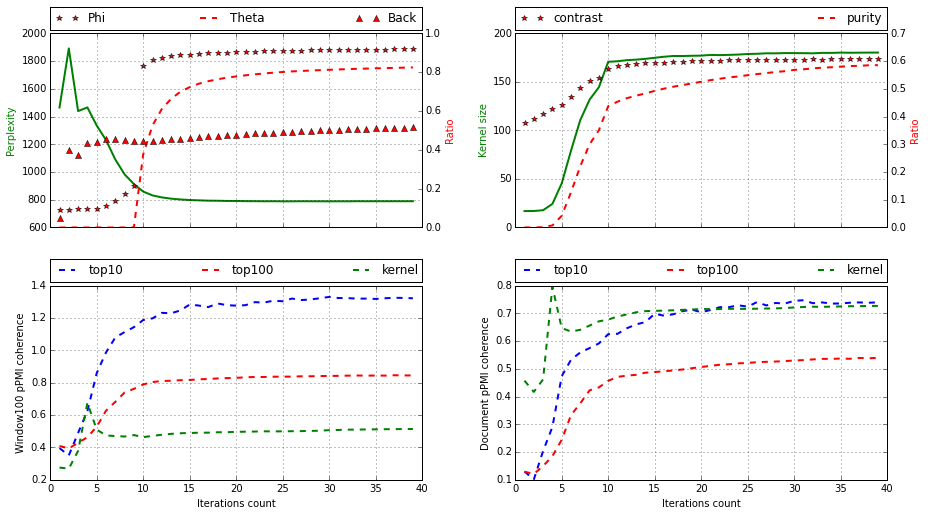

In [2]:
model = artm.ARTM(topic_names = all_topics, num_processors=3)
prepare(model)

model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.1, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+5, topic_names=domain_topics))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10, use_ptdw_matrix=True)

model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.5, topic_names=domain_topics))
theta, markup = model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30, 
                                        use_ptdw_matrix=True, find_theta_ptdw=True)

figures(model)

### Выгружаю тету с обучения с помощью fit_transform. Вижу очень разреженную матрицу, в которой меньше тем, чем в разметке.

In [16]:
import pandas
phi = model.phi_.sort(axis=0)
theta_fit_transform = model.fit_transform().sort(axis=1)

In [18]:
print theta_fit_transform

         1         2         3         4         5         6         7     \
0    0.000000  0.000000  0.002732  0.000000  0.000000  0.000000  0.000000   
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.019753  0.000000   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.023727   
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.000000  0.002012  0.000000  0.000000  0.000000  0.000000  0.000000   
5    0.000000  0.000000  0.000000  0.007897  0.000000  0.000000  0.000000   
6    0.016058  0.024140  0.000000  0.000000  0.000000  0.000000  0.000000   
7    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8    0.247113  0.000000  0.000000  0.000000  0.000000  0.024611  0.000000   
9    0.000000  0.012408  0.000000  0.000000  0.000000  0.000000  0.000000   
10   0.000000  0.000000  0.000000  0.000000  0.000000  0.093585  0.000000   
11   0.000000  0.000000  0.000000  0.000000  0.001591  0.024194  0.000000   

### Печатаю тету, выгруженную мне с помощью process_batches в конце fit_offline. Она плотная.

In [8]:
print theta

         1001      1002      1003      1004      1005      1006      1007  \
0    0.020017  0.009582  0.017380  0.009514  0.005013  0.005658  0.011706   
1    0.017609  0.026474  0.009763  0.004981  0.006430  0.008699  0.006175   
2    0.008755  0.005180  0.015958  0.158152  0.012136  0.004020  0.006152   
3    0.008398  0.013048  0.012260  0.014261  0.009412  0.006149  0.010037   
4    0.014591  0.009374  0.006336  0.010942  0.008634  0.219016  0.019530   
5    0.008005  0.018668  0.011548  0.023919  0.010930  0.009991  0.006694   
6    0.006938  0.009410  0.008321  0.021989  0.007941  0.005870  0.009003   
7    0.011558  0.013285  0.010688  0.013535  0.022499  0.008831  0.010713   
8    0.013305  0.048445  0.011369  0.013979  0.007934  0.014698  0.008140   
9    0.023457  0.008670  0.019757  0.012871  0.010405  0.008530  0.007689   
10   0.010987  0.006537  0.008564  0.008680  0.005352  0.009868  0.006475   
11   0.015289  0.043418  0.016850  0.006080  0.024158  0.016239  0.025608   

### Темы для документа 738 согласно плотной тете с process_batches:

In [13]:
sorted_theta_np = theta.sort(axis=1).as_matrix()
for i in range(theta.as_matrix().shape[0]):
    if sorted_theta_np[i][738] != 0:
        print i, sorted_theta_np[i][738]

0 0.00124151
1 0.0141011
2 0.00113324
3 0.00697132
4 0.0137292
5 0.0140787
6 0.00675212
7 0.0153882
8 0.0137051
9 0.00791135
10 0.00965475
11 0.00533609
12 0.00386914
13 0.00143831
14 0.0120886
15 0.0158684
16 0.000236977
17 0.0138492
18 0.00277294
19 0.00136322
20 0.0156227
21 0.00946594
22 0.00231368
23 0.00694916
24 0.0190615
25 0.00727215
26 0.00869366
27 0.00322297
28 0.0101606
29 0.00966415
30 0.021989
31 0.00605928
32 0.00866879
33 0.00913409
34 0.120019
35 0.00466064
36 0.0206934
37 0.00400477
38 0.00482324
39 0.00548079
40 0.0152544
41 0.0124094
42 0.00164683
43 0.212508
44 0.00319626
45 0.00832781
46 0.00744893
47 0.0109843
49 0.0286018
50 0.0909995
51 0.149173


### Темы того же документа согласно разреженной тете с fit_transform. 
(Меня кстати удивляет название этой функции, в ней есть fit, но де факто она ничего не обучает, просто вытаскивает тету с обучения из кэша, насколько я понимаю.)

In [12]:
for i in range(theta_fit.as_matrix().shape[0]):
    if theta_fit.as_matrix()[i][738] != 0:
        print i, theta_fit.as_matrix()[i][738]

43 0.376327
50 0.399063
51 0.224611


### Разметка того же документа:

In [14]:
import codecs
texts = []
titles = []
with codecs.open("datasets/mmro_order/vw.mmro.txt", "r", encoding='utf-8') as f:
    for line in f:
        l = line.split()
        titles.append(l[0])
        texts.append(l[1:])

In [15]:
text_id = 738
print titles[text_id]
for i in range(len(texts[text_id])):
    print texts[text_id][i], markup[text_id + 1][i], "  ",

2013-MMRO16/Shibzukhov_2
агрегированный 43    корректный 43    операция 34    алгоритм 51    агрегированный 43    корректный 43    операция 34    алгоритм 51    матросов 43    шибзухов 43    матросов 43    виктор 43    шибзухов 43    настоящий 50    работа 50    обсуждаться 43    корректный 43    операция 34    алгоритм 51    возникать 43    связь 50    проблема 50    построение 49    корректный 43    алгоритм 51    корректный 43    операция 34    образовать 5    значительный 43    подкласс 34    корректировать 34    операция 34    обладать 51    важный 50    свойство 36    сохранять 34    свойство 36    корректность 20    алгоритм 51    типичный 43    задача 50    поиск 50    корректный 43    операция 34    возникать 43    использовать 51    метод 51    обучение 51    позволять 51    строить 34    множество 51    различный 51    алгоритм 51    корректный 43    свой 51    обучать 51    множество 51    обладать 51    достаточно 51    хороший 51    качество 51    функционирование 43    к